In [1]:
import matplotlib.pyplot as plt
import torch
from torch.nn import Conv2d, CrossEntropyLoss, Linear, MaxPool2d, Module
from torch.nn.functional import relu
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision.transforms.v2 import Compose, ToTensor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according 

In [2]:
# Define the transformation to apply to the data
transform = Compose([ToTensor()])

# Load the Fashion-MNIST dataset
trainset = FashionMNIST(
    "fashion-mnist_data", download=True, train=True, transform=transform
)
testset = FashionMNIST(
    "fashion-mnist_data", download=True, train=False, transform=transform
)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Define the data loaders for the training, validation, and testing sets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


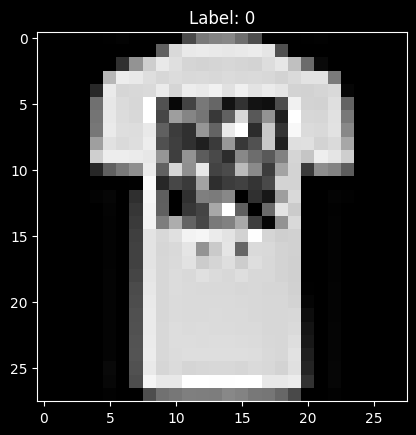

In [3]:
# Get a random image from the training set
image, label = trainset[0]

# Plot the image
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [4]:
device = torch.device("mps")

In [5]:
class ConvNet(Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = Linear(64 * 7 * 7, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.pool(x)
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet().to(device)

In [7]:
# Define the loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 5
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs = inputs.to(
            device, dtype=torch.float32
        )  # convert input tensor to float32
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy and loss
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Print statistics
        if i % 100 == 99:
            # Compute validation accuracy and loss
            correct_val = 0
            total_val = 0
            val_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    images = images.to(
                        device, dtype=torch.float32
                    )  # convert input tensor to float32
                    labels = labels.to(device)
                    images, labels = data
                    images = images.to(
                        device, dtype=torch.float32
                    )  # convert input tensor to float32
                    labels = labels.to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            print(
                f"[Epoch {epoch + 1}, Batch {i + 1}] "
                f"Train Loss: {running_loss / 100:.3f} "
                f"Train Acc: {100 * correct_train / total_train:.2f}% "
                f"Val Loss: {val_loss / len(valloader):.3f} "
                f"Val Acc: {100 * correct_val / total_val:.2f}%"
            )
            running_loss = 0.0
            correct_train = 0
            total_train = 0

[Epoch 1, Batch 100] Train Loss: 0.914 Train Acc: 67.06% Val Loss: 0.577 Val Acc: 78.17%
[Epoch 1, Batch 200] Train Loss: 0.558 Train Acc: 79.28% Val Loss: 0.495 Val Acc: 82.45%
[Epoch 1, Batch 300] Train Loss: 0.466 Train Acc: 83.48% Val Loss: 0.434 Val Acc: 84.61%
[Epoch 1, Batch 400] Train Loss: 0.434 Train Acc: 83.77% Val Loss: 0.411 Val Acc: 84.92%
[Epoch 1, Batch 500] Train Loss: 0.412 Train Acc: 85.03% Val Loss: 0.435 Val Acc: 84.25%
[Epoch 1, Batch 600] Train Loss: 0.363 Train Acc: 86.77% Val Loss: 0.356 Val Acc: 87.30%
[Epoch 1, Batch 700] Train Loss: 0.366 Train Acc: 86.70% Val Loss: 0.336 Val Acc: 88.17%
[Epoch 2, Batch 100] Train Loss: 0.331 Train Acc: 87.91% Val Loss: 0.362 Val Acc: 86.89%
[Epoch 2, Batch 200] Train Loss: 0.315 Train Acc: 88.42% Val Loss: 0.355 Val Acc: 87.10%
[Epoch 2, Batch 300] Train Loss: 0.318 Train Acc: 88.50% Val Loss: 0.352 Val Acc: 87.36%
[Epoch 2, Batch 400] Train Loss: 0.319 Train Acc: 88.67% Val Loss: 0.298 Val Acc: 89.47%
[Epoch 2, Batch 500] 

In [8]:
# Compute test accuracy and loss
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(
    f"Test Loss: {test_loss / len(testloader):.3f} "
    f"Test Acc: {100 * correct_test / total_test:.2f}%"
)

Test Loss: 0.267 Test Acc: 90.60%
